In [38]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

Load datasets

In [39]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

Merge Customers.csv and Transactions.csv to get customer profile and transaction data.
Aggregate transaction information for each customer (e.g., total spending, quantity purchased).

In [40]:

customer_transactions = transactions.groupby("CustomerID").agg({
    "TotalValue": "sum",
    "Quantity": "sum"
}).reset_index()
customer_transactions


,CustomerID,TotalValue,Quantity
0,C0001,3354.52,12
1,C0002,1862.74,10
2,C0003,2725.38,14
3,C0004,5354.88,23
4,C0005,2034.24,7
...,...,...,...
194,C0196,4982.88,12
195,C0197,1928.65,9
196,C0198,931.83,3
197,C0199,1979.28,9


Fill missing values (if any)

In [41]:

customer_data = customers.merge(customer_transactions, on="CustomerID", how="left")


customer_data.fillna(0, inplace=True)
customer_data

,CustomerID,CustomerName,Region,SignupDate,TotalValue,Quantity
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,12.0
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,10.0
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,14.0
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,23.0
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,7.0
...,...,...,...,...,...,...
195,C0196,Laura Watts,Europe,2022-06-07,4982.88,12.0
196,C0197,Christina Harvey,Europe,2023-03-21,1928.65,9.0
197,C0198,Rebecca Ray,Europe,2022-02-27,931.83,3.0
198,C0199,Andrea Jenkins,Europe,2022-12-03,1979.28,9.0


One-hot encode categorical features (Region)
Select features for clustering

In [42]:

customer_data_encoded = pd.get_dummies(customer_data, columns=["Region"], drop_first=True)

features = ["TotalValue", "Quantity"] + [col for col in customer_data_encoded.columns if col.startswith("Region")]
X = customer_data_encoded[features]
X

,TotalValue,Quantity,Region_Europe,Region_North America,Region_South America
0,3354.52,12.0,False,False,True
1,1862.74,10.0,False,False,False
2,2725.38,14.0,False,False,True
3,5354.88,23.0,False,False,True
4,2034.24,7.0,False,False,False
...,...,...,...,...,...
195,4982.88,12.0,True,False,False
196,1928.65,9.0,True,False,False
197,931.83,3.0,True,False,False
198,1979.28,9.0,True,False,False


Standardize the features

In [43]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.05188436, -0.1107351 , -0.57735027, -0.54653573,  1.54590766],
       [-0.86271433, -0.43404927, -0.57735027, -0.54653573, -0.64686916],
       [-0.393842  ,  0.21257907, -0.57735027, -0.54653573,  1.54590766],
       [ 1.03537505,  1.66749283, -0.57735027, -0.54653573,  1.54590766],
       [-0.76949861, -0.91902053, -0.57735027, -0.54653573, -0.64686916],
       [ 0.42264614, -0.1107351 , -0.57735027, -0.54653573,  1.54590766],
       [-0.47295849, -0.75736344, -0.57735027, -0.54653573, -0.64686916],
       [ 0.44658328,  1.18252158, -0.57735027,  1.82970656, -0.64686916],
       [-1.38789656, -1.56564887,  1.73205081, -0.54653573, -0.64686916],
       [-0.94162972, -0.1107351 ,  1.73205081, -0.54653573, -0.64686916],
       [ 0.15220099,  0.05092198, -0.57735027, -0.54653573,  1.54590766],
       [ 0.96818364,  1.02086449, -0.57735027, -0.54653573,  1.54590766],
       [ 1.38632271,  0.85920741, -0.57735027, -0.54653573,  1.54590766],
       [-1.70197101, -1.72730595,  1.7

Used K-Means clustering for simplicity and scalability.
No. of clusters: 2 to 10
then calculate metrics.

In [44]:
db_scores = []
silhouette_scores = []
cluster_range = range(2, 11)
models = []

for k in cluster_range:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_scaled)
    models.append(model)


    db_index = davies_bouldin_score(X_scaled, labels)
    silhouette_avg = silhouette_score(X_scaled, labels)
    db_scores.append(db_index)
    silhouette_scores.append(silhouette_avg)

Select optimal number of clusters (minimum DB Index)
Add cluster labels to the dataset

In [45]:

optimal_k = cluster_range[np.argmin(db_scores)]
optimal_model = models[np.argmin(db_scores)]
optimal_labels = optimal_model.labels_

customer_data["Cluster"] = optimal_labels
customer_data

,CustomerID,CustomerName,Region,SignupDate,TotalValue,Quantity,Cluster
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,12.0,6
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,10.0,1
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,14.0,6
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,23.0,2
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,7.0,1
...,...,...,...,...,...,...,...
195,C0196,Laura Watts,Europe,2022-06-07,4982.88,12.0,0
196,C0197,Christina Harvey,Europe,2023-03-21,1928.65,9.0,4
197,C0198,Rebecca Ray,Europe,2022-02-27,931.83,3.0,4
198,C0199,Andrea Jenkins,Europe,2022-12-03,1979.28,9.0,4


Used PCA to reduce the data to 2D for visualizing clusters.


In [46]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_pca

array([[ 3.06720182e-01,  1.69161243e+00],
       [-9.07036873e-01,  1.72387090e-01],
       [ 2.93622252e-01,  1.68698870e+00],
       [ 2.26671572e+00,  1.19643844e+00],
       [-1.17474823e+00,  2.45751034e-01],
       [ 6.31603468e-01,  1.61650947e+00],
       [-8.61214314e-01,  1.69445905e-01],
       [ 9.93711044e-01, -1.33275088e+00],
       [-2.38518739e+00, -4.56389368e-01],
       [-1.08506246e+00, -7.91370113e-01],
       [ 5.56955721e-01,  1.62993993e+00],
       [ 1.77867275e+00,  1.32456203e+00],
       [ 1.95443788e+00,  1.28775635e+00],
       [-2.71072604e+00, -3.77309116e-01],
       [-1.93329676e+00, -5.94904636e-01],
       [-2.59195438e-01, -1.00485979e+00],
       [ 1.03940008e+00, -1.31691221e+00],
       [ 9.62563372e-01, -1.31789893e+00],
       [-1.02131796e+00, -8.02280083e-01],
       [-2.13128230e+00, -5.45310717e-01],
       [ 1.19024857e+00, -3.39220932e-01],
       [ 6.84608682e-01, -2.14681059e-01],
       [ 4.16475593e-01, -1.14613084e+00],
       [ 9.

Plotted customer segments to interpret clustering results.

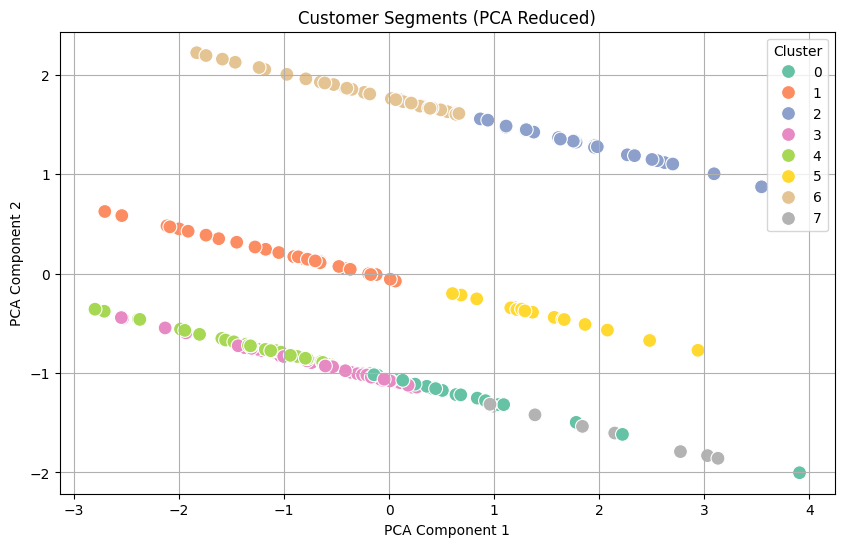

In [47]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=customer_data["Cluster"], palette="Set2", s=100)
plt.title("Customer Segments (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid()
plt.show()

Clustering results

Metrics:

DB Index: Lower values indicate better-defined clusters.
Silhouette Score: Higher values indicate better separation between clusters.

In [48]:
optimal_db_index = db_scores[np.argmin(db_scores)]
optimal_silhouette = silhouette_scores[np.argmin(db_scores)]

print(f"Optimal Number of Clusters: {optimal_k}")
print(f"Davies-Bouldin Index (Optimal): {optimal_db_index:.4f}")
print(f"Silhouette Score (Optimal): {optimal_silhouette:.4f}")


Optimal Number of Clusters: 8
Davies-Bouldin Index (Optimal): 0.6329
Silhouette Score (Optimal): 0.5316
